# 6 통계적 머신러닝
## Subtitles:
1. K 최근접 이웃 (K Nearest Neighbor, KNN)
2. 트리 모델 (Tree Model)
3. 배깅과 랜덤포레스트
4. 부스팅

## 들어가면서...
* 데이터에 기반하여 전체적인 구조가 선형이 아니라는 가정하에 고전적 통계 방법에서 벗어나서 발전시켜왔다.
* 대표적으로 KNN이나 앙상블 학습을 적용한 의사 결정 트리가 있다.
* 90년대 이후에는 배깅과 부스팅 앙상블 방법을 통해 통계적 머신러닝의 토대를 만들었다.


## 6.1 K 최근접 이웃 (K Nearest Neighbor)
* KNN은 아래와 같은 아이디어에서 출발하였다.
 1. 특징(독립변수)이 유사한 K개의 레코드를 찾는다.
 2. **분류**: 유사한 레코드 중에 다수가 속한 클래스가 무엇인지 찾운 후에 새로운 레코드를 그 클래스에 할당한다.
 3. **예측(KNN Regression)**: 유사항 레코드들의 평균을 찾아서 새로운 레코드에 대한 예측값으로 사용한다.

* KNN은 예측하려는 레코드에 대해 유사한 레코드들이 속한 클래스로 분류하는 방법이다.
* 유사성은 유클리드 거리, 맨해튼 거리 또는 마할리노비스 거리 중에서 하나를 사용하여 결정한다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### 6.1.1 대출 연체 예측
* 이 예제는 P2P 방식의 대출업체인 '렌딩클럽'의 데이터로, 새로운 대출자의 상태에 따라 대출의 결과를 예측하고 한다.

In [2]:
loan_data = pd.read_csv('../data/loan_data.csv')
loan_data.head()

,Unnamed: 0,status,loan_amnt,term,annual_inc,dti,payment_inc_ratio,revol_bal,revol_util,purpose,...,delinq_2yrs_zero,pub_rec_zero,open_acc,grade,outcome,emp_length,purpose_,home_,emp_len_,borrower_score
0,1,Charged Off,2500,60 months,30000,1.00,2.39320,1687,9.4,car,...,1,1,3,4.8,default,1,major_purchase,RENT,> 1 Year,0.65
1,2,Charged Off,5600,60 months,40000,5.55,4.57170,5210,32.6,small_business,...,1,1,11,1.4,default,5,small_business,OWN,> 1 Year,0.80
2,3,Charged Off,5375,60 months,15000,18.08,9.71600,9279,36.5,other,...,1,1,2,6.0,default,1,other,RENT,> 1 Year,0.60
3,4,Charged Off,9000,36 months,30000,10.08,12.21520,10452,91.7,debt_consolidation,...,1,1,4,4.2,default,1,debt_consolidation,RENT,> 1 Year,0.50
4,5,Charged Off,10000,36 months,100000,7.06,3.90888,11997,55.5,other,...,1,1,14,5.4,default,4,other,RENT,> 1 Year,0.55


* 위 독립변수 중 두 가지 변수만들 고려하여 간단한 모델을 만들어 보자.
 * payment_inc_ratio: 소득 대비 대출 상환 비율
 * dti: 소득에 대한 부채 비율

In [3]:
# 6.1.1 simple KNN on payment_inc_ratio and dti

loan_data200 = pd.read_csv('../data/loan200.csv')
loan_data_1_1 = loan_data200.copy()
loan_data_1_1.head(6)

,outcome,payment_inc_ratio,dti
0,target,9.00000,22.50
1,default,5.46933,21.33
2,paid off,6.90294,8.97
3,paid off,11.14800,1.83
4,default,3.72120,10.81
5,paid off,1.89923,11.34


* K (neighbor)수를 20으로 하여, 0번 대출자(payment_inc_ratio = 9, dtl = 22.5)에 대한 예측 결과를 사용해보면 아래와 같이 상환('paid off')이라는 예측을 해주고 있다.

In [4]:
# 6.1.1 (cont')
from sklearn.neighbors import KNeighborsClassifier

# training on KNN from sklearn
#knn_1_1 = NearestNeighbors(n_neighbors=20, algorithm='ball_tree')
knn_1_1 = KNeighborsClassifier(n_neighbors=20, algorithm='ball_tree')

# test <- first data
test = loan_data_1_1.iloc[0, 1:3]
test = np.array(test).reshape(1,2)

# x_train <- payment_inc_ratio and dti
# y_train <- outcome
x_train = loan_data_1_1.iloc[1:,1:3]
y_train = loan_data_1_1.iloc[1:,0]

# fitting with x and y
knn_1_1.fit(x_train, y_train)

# predicting test's class
result_1_1 = knn_1_1.predict(test)
print(result_1_1[0])

paid off


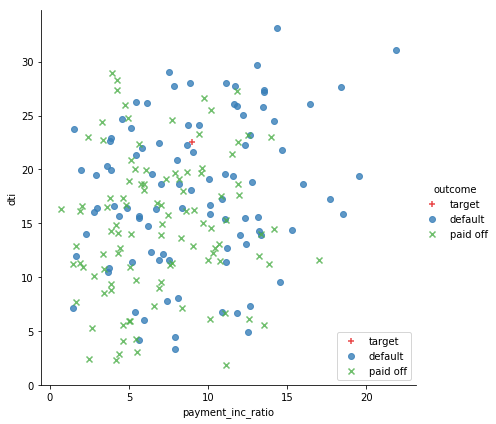

In [5]:
# 6.1.1 (Cont') Visualization of KNN outcome
sns.lmplot( x="payment_inc_ratio", y="dti", data=loan_data200, fit_reg=False, hue='outcome', legend=True, 
           palette="Set1", markers=["+","o", "x"], height=6 , aspect=1)
plt.legend(loc='lower right')

### 6.1.2 거리 지표

* 유사성(또는 근접성 nearness, similarity)는 거리 지표를 통해서 결정된다.
* 거리 지표로는 유클리드 거리(Euclidean Distance)가 가장 많이 사용된다.  그 다음으로는 맨해탄 거리(Manhattan Distance)가 사용된다.

### 6.1.3 원-핫 인코더
* KNN도 범주형 변수에 대해서는 원-핫 인코딩을 해주어야 한다.

### 6.1.4 표준화, 정규화, Z점수
* 각 독립변수들에 대해 평균에서 얼마나 차이가 나는지 확인하고자 할때, 각 변수마다 서로 다른 스케일때문에 확인에 어려움이 있을 수 있다.
* 표준화(또는 정규화, z값)는 독립변수를 동일한 스케일에서 관찰할 수 있도록 한다. 

 $ z = \displaystyle {x - \bar x \over s} $
 
* 독립변수 x가 평균($\bar x$)에서 얼마나 떨어져 있는지 표준편차($s$)의 단위로 나타낸다.
* z점수는 변수를 표준화하는 하나의 방법이며, 평균대신 중간값처럼 로버스트한 추정값을 사용할 수도 있다.  
* 또한, 변수의 표준화의 의미는 모든 독립변수를 예측에 대한 중요성을 동일하게 맞추는 의미인데, 특정 독립변수가 중요하다고 생각하는 경우에는 동일한 스케일이 아니라 다른 스케일을 적용할 수도 있다.

In [6]:
# 6.1.4 Standardization, Regularization and Z score

loan_data = pd.read_csv('../data/loan_data.csv')
features_1_4 = ['outcome','payment_inc_ratio', 'dti', 'revol_bal', 'revol_util']
loan_data_1_4 = loan_data[features_1_4]
loan_data_1_4.head(6)

,outcome,payment_inc_ratio,dti,revol_bal,revol_util
0,default,2.39320,1.00,1687,9.4
1,default,4.57170,5.55,5210,32.6
2,default,9.71600,18.08,9279,36.5
3,default,12.21520,10.08,10452,91.7
4,default,3.90888,7.06,11997,55.5
5,default,8.01977,13.22,32135,90.3


* 아래 코드는 표준화없이 적용한 결과이고, 'Paid Off'로 예측하였다.  
* 결과는 Test용 데이터이고, 그 아래 테이블은 Test 데이터와 가장 가까운 상위 5개의 데이터(Nearest Neighbor)를 보여준 것이다.

In [7]:
# 6.1.4 (cont') without scaling

# training on KNN from sklearn
knn_1_4 = KNeighborsClassifier(n_neighbors=5, radius=0.5, algorithm='ball_tree')

# test <- first data
test = loan_data_1_4.iloc[0,1:]
test = np.array(test).reshape(1,4)

# print test data
for col, idx in zip(loan_data_1_4.columns[1:], range(0,len(loan_data_1_4.columns[1:]))):
    print('%s : %f'%(col, test[0,idx]))

# x_train <- payment_inc_ratio and dti
# y_train <- outcome
x_train = loan_data_1_4.iloc[1:,1:5]
y_train = loan_data_1_4.iloc[1:,0]

# fitting with X and y
knn_1_4.fit(X=x_train, y=y_train)

# querying nearest neighbors of 'test' and get the nearest neighbor's outcome
distance_1_4, result_1_4 = knn_1_4.kneighbors(test)
pred_1_4 = knn_1_4.predict(test)
print('predicted class: %s'%pred_1_4[0])
loan_data_1_4.iloc[result_1_4[0]]

payment_inc_ratio : 2.393200
dti : 1.000000
revol_bal : 1687.000000
revol_util : 9.400000
predicted class: paid off


,outcome,payment_inc_ratio,dti,revol_bal,revol_util
35535,paid off,8.30143,11.38,10074,69.5
33650,paid off,7.04082,21.81,25639,76.1
25862,paid off,4.14828,12.96,7302,88.0
42952,paid off,9.14223,1.23,7918,19.8
43598,paid off,2.50637,7.65,43305,48.7


* 아래 코드는 표준화(스케일링)을 수행한 후 결과이다. 
* 예측한 내용은 'Paid Off'로 변경되지 않았으나, 이웃이 바뀐 것을 확인 할 수 있다.
* 표준화에 따른 이웃의 변화를 보기 위한 것으로, 필요한 전체 데이터를 사용하지 않았기 때문에 결과가 다소 이상할 수 있다.

In [8]:
# 6.1.4 (cont') with scaling

from sklearn import preprocessing

# scaling original data
loan_data_1_4_std = pd.DataFrame()
for cols in ['payment_inc_ratio', 'dti', 'revol_bal', 'revol_util']:
    loan_data_1_4_std[cols] = preprocessing.scale(loan_data_1_4[cols])

# test <- first data
test = loan_data_1_4_std.iloc[0]
test = np.array(test).reshape(1,4)

knn_1_4_std = KNeighborsClassifier(n_neighbors=5, radius=0.5, algorithm='kd_tree')

# print test data
for col, idx in zip(loan_data_1_4.columns[1:], range(0,len(loan_data_1_4.columns[1:]))):
    print('%s : %f'%(col, test[0,idx]))

# x_train <- payment_inc_ratio and dti
# y_train <- outcome
x_train_std = loan_data_1_4_std.iloc[1:]
y_train_std = loan_data_1_4.iloc[1:,0]

# fitting with X and y
knn_1_4_std.fit(X=x_train_std, y=y_train_std)

# querying nearest neighbors of 'test' and get the nearest neighbor's outcome
distance_1_4_std, result_1_4_std = knn_1_4_std.kneighbors(test)
pred_1_4_std = knn_1_4_std.predict(test)
print('predicted class: %s'%pred_1_4_std[0])
loan_data_1_4.iloc[result_1_4_std[0]]

payment_inc_ratio : -1.322477
dti : -1.992645
revol_bal : -0.655823
revol_util : -1.834519
predicted class: paid off


,outcome,payment_inc_ratio,dti,revol_bal,revol_util
2079,default,10.04400,19.89,9179,51.5
1437,default,3.87890,5.31,1687,51.1
30214,paid off,6.71820,15.44,4295,26.0
28541,paid off,6.93816,20.31,11182,76.1
44736,paid off,8.20170,16.65,5244,73.9


### 6.1.5 K선택하기

* KNN에서 K의 선택은 성능을 결정짓는 중요 요소이다.
* K가 너무 작으면 노이즈까지 고려한 오버피팅 문제가 발생할 수 있고, K가 너무 크면 오버스무딩되어서 지역정보를 예측하는 KNN의 기능을 제대로 발휘하기 어렵다.
* 데이터에 노이즈가 거의 없고, 구조화가 잘 된 데이터는 K가 작을때 잘 동작한다. 반대로 노이즈가 많은 경우 K가 클수록 좋다.
* 최적의 K를 찾는 과정은 탐색과정과 비슷해서, K값에 대한 오분류율을 바탕으로 최적의 K값을 찾아가야 한다.


### 6.1.6 KNN을 통한 피처 엔지니어링

* KNN은 구현이 간단하고 직관적인 장점이 있으나, 성능면에서 경쟁력이 높지는 않다.
* 다만, 다른 분류 알고리즘/방법들의 특정 단계에서 모델에 '지역적인 정보(local knowledge)'를 추가하기 위해 사용할 수 있다.  이 추가된 지역정보를 새로운 피처로 사용해서, 독립변수처럼 활용할 수 있다.
  (이런 경우, 다중공성선이 우려될 수도 있으나, 실제로는 지역적인 정보로 활용되기 때문에 이러한 문제는 없다고 알려져 있다)  
* 아파트나 주택 매매의 경우, 부동산 중계업자는 최근에 팔린 비슷한 집들의 가격으로 기준 삼아 매매 가격을 예측할 것이다.  일종의 수동 KNN을 하는 것이라고 볼 수 있다.
* 아래 코드는 대출데이터를 이용하여 대출을 갚지 못할 확률을 예상하는 피처를 추가하였다.

In [9]:
# 6.1.6 Feature Engineering by KNN

borrow_1_6_features = ['outcome', 'dti', 'revol_bal', 'revol_util', 'open_acc', 'delinq_2yrs_zero', 'pub_rec_zero']
borrow_1_6 = loan_data[borrow_1_6_features]
borrow_1_6.head()

,outcome,dti,revol_bal,revol_util,open_acc,delinq_2yrs_zero,pub_rec_zero
0,default,1.00,1687,9.4,3,1,1
1,default,5.55,5210,32.6,11,1,1
2,default,18.08,9279,36.5,2,1,1
3,default,10.08,10452,91.7,4,1,1
4,default,7.06,11997,55.5,14,1,1


In [10]:
# 6.1.6 (cont')

# test <- first data
test = borrow_1_6.iloc[0, 1:7]
test = np.array(test).reshape(1,6)

knn_1_6 = KNeighborsClassifier(n_neighbors=10, algorithm='ball_tree')

for cols, idx in zip(borrow_1_6.columns[1:], range(0, len(borrow_1_6.columns[1:]))):
    print('%s : %f'%(cols, test[0,idx]))
print()

# x_train <- 'dti', 'revol_bal', 'revol_util', 'open_acc', 'delinq_2yrs_zero', 'pub_rec_zero'
# y_train <- 'outcome'
x_train = borrow_1_6.iloc[1:,1:]
y_train = borrow_1_6.iloc[1:,0]

# fitting with X and y
knn_1_6.fit(X=x_train, y=y_train)

# querying nearest neighbors of 'test' and get the nearest neighbor's outcome
distance_1_6, result_1_6 = knn_1_6.kneighbors(test)
pred_1_6 = knn_1_6.predict(test)
print('predicted class: %s'%pred_1_6[0])
prob_1_6 = knn_1_6.predict_proba(test)
print('paid-off probability: %f'%prob_1_6[0,1])

dti : 1.000000
revol_bal : 1687.000000
revol_util : 9.400000
open_acc : 3.000000
delinq_2yrs_zero : 1.000000
pub_rec_zero : 1.000000

predicted class: paid off
paid-off probability: 0.700000


In [11]:
pred_all_1_6 = knn_1_6.predict_proba(borrow_1_6.iloc[:,1:7])
borrow_1_6['default_prob'] = pred_all_1_6[:,0]
borrow_1_6['prob'] = borrow_1_6['default_prob']

for idx in range(0, borrow_1_6.shape[0]):
    if borrow_1_6.iloc[idx, 0] != 'default':
        #if idx % 1000 == 0:
        #    print('idx: %d'%idx)
        borrow_1_6.iloc[idx, 8] = 1 - borrow_1_6.iloc[idx, 7]        
borrow_1_6.head()

# lambda takes forever
#borrow_1_6['prob'] = borrow_1_6.outcome.apply(lambda x: borrow_1_6.default_prob if x == 'default' else (1 - borrow_1_6.default_prob))

,outcome,dti,revol_bal,revol_util,open_acc,delinq_2yrs_zero,pub_rec_zero,default_prob,prob
0,default,1.00,1687,9.4,3,1,1,0.3,0.3
1,default,5.55,5210,32.6,11,1,1,0.3,0.3
2,default,18.08,9279,36.5,2,1,1,0.5,0.5
3,default,10.08,10452,91.7,4,1,1,0.5,0.5
4,default,7.06,11997,55.5,14,1,1,0.6,0.6


In [12]:
# 6.1.6 (cont')
borrow_1_6.prob.describe()

count    45342.000000
mean         0.561707
std          0.161138
min          0.100000
25%          0.500000
50%          0.600000
75%          0.700000
max          1.000000
Name: prob, dtype: float64

## 6.2 트리 모델

* 트리 모델은 CART(Classification and regression tree) 또는 의사 결정 트리(Decision Tree)로 불린다.
* 랜덤 포레스트(Random Forest)와 부스트(Boost)와 같은 강력한 예측 모델의 기초가 되는 방법이다.
* 간단히 말해, if-then-else 규칙의 집합체이다.  복잡한 상호 관계(다중공선성 등)에 따른 숨겨진 패턴들을 발견하는 데 탁월하다.

In [13]:
# 6.2.1 Simple Example from loan3000.csv

loan_data3000 = pd.read_csv('../data/loan3000.csv')
features_2_1 = ['outcome', 'borrower_score', 'payment_inc_ratio']
loan_2_1 = loan_data3000[features_2_1]
loan_2_1.head()

,outcome,borrower_score,payment_inc_ratio
0,paid off,0.40,5.11135
1,default,0.40,5.43165
2,paid off,0.70,9.23003
3,paid off,0.40,2.33482
4,default,0.45,12.10320


### 6.2.1 대출 데이터 예제

* 3000개의 단순화한 대출 데이터로 트리를 만들어 예측해보자.
* 첫 번째 대출자(borrower_score = 0.40과 payment_inc_ratio = 5.11135)에 대한 예측은 아래와 같이 'Paid off'로 되었다.

In [14]:
# 6.2.1 (Cont') 

from sklearn import tree

test = loan_2_1.iloc[0, 1:]
test = np.array(test).reshape(1,2)

# Sklearn's Decision Tree doesn't support the direct pruning parameter such as R's cp in rpart.
clf = tree.DecisionTreeClassifier(max_depth=4)

# x_train <- 'borrower_score', 'payment_inc_ratio'
# y_train <- 'outcome'
x_train = loan_2_1[features_2_1[1:]]
y_train = loan_2_1[features_2_1[0]]

# fitting with X and y
clf.fit(X=x_train, y=y_train)
clf.predict(test)[0]

'paid off'

* 아래 코드를 통해서 위 트리 모델에 대한 시각화를 할 수 있다.
* borrow_score와 payment_inc_ratio에 대한 조건외에도, gini(지니 불순도), samples, node의 value와 class를 확인 할 수 있다.

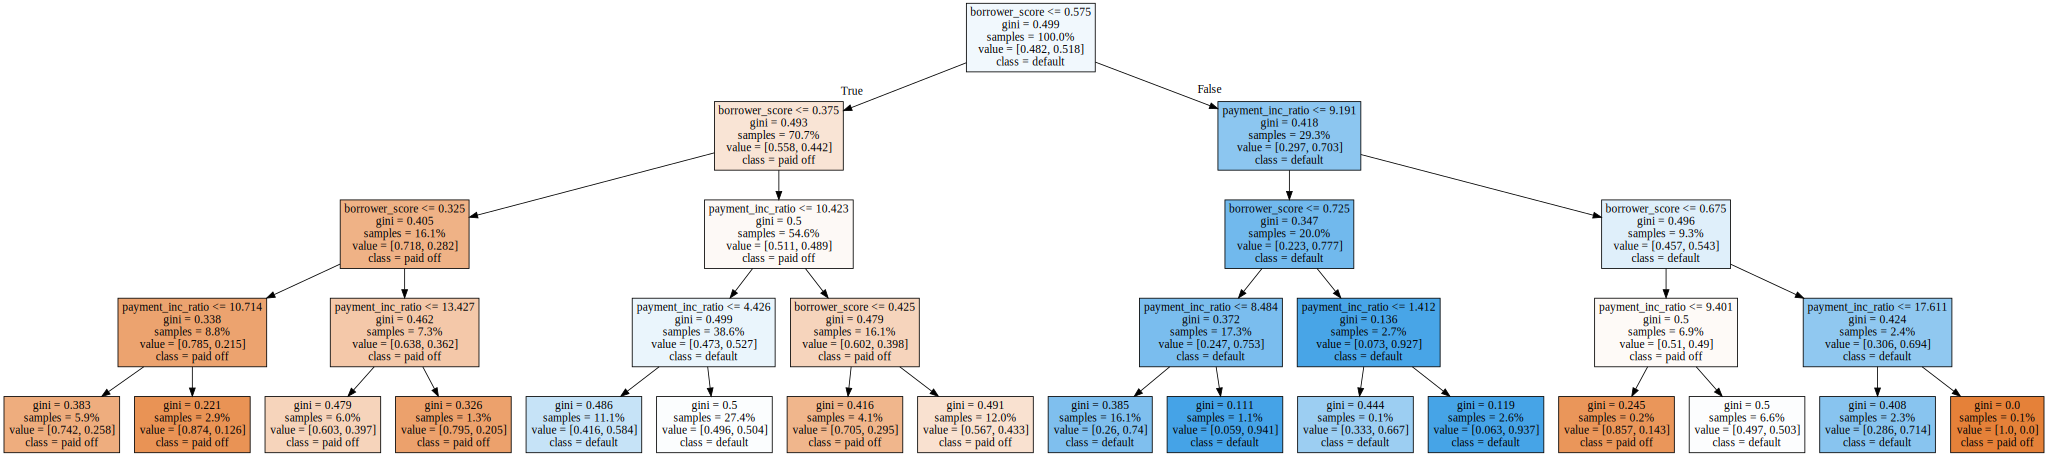

In [15]:
# 6.2.1 (Cont') Graphical visualization of simple Decision Tree
import gc
import graphviz

# Graphically visualizing tree.
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=features_2_1[1:], class_names=y_train.unique(), proportion=True, filled=True)  
graph = graphviz.Source(dot_data)
graph

* 아래 코드를 통해서 위 트리 모델에 대한 텍스트 기반 시각화를 할 수 있다.

In [16]:
# 6.2.1 (Cont') Text Tree structure of simple Decision Tree

n_nodes = clf.tree_.node_count
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)

children_left = clf.tree_.children_left
children_right = clf.tree_.children_right
feature = clf.tree_.feature
threshold = clf.tree_.threshold

stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True
        
print("The binary tree structure has %s nodes and has "
      "the following tree structure:"
      % n_nodes)
for i in range(n_nodes):
    if is_leaves[i]:
        print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
    else:
        print("%snode=%s test node: go to node %s if X[:, %s] <= %s else to node %s."% 
              (node_depth[i] * "\t",i,children_left[i],feature[i],threshold[i],children_right[i],)
             )
print()


The binary tree structure has 31 nodes and has the following tree structure:
node=0 test node: go to node 1 if X[:, 0] <= 0.5750000178813934 else to node 16.
	node=1 test node: go to node 2 if X[:, 0] <= 0.375 else to node 9.
		node=2 test node: go to node 3 if X[:, 0] <= 0.32500000298023224 else to node 6.
			node=3 test node: go to node 4 if X[:, 1] <= 10.714100360870361 else to node 5.
				node=4 leaf node.
				node=5 leaf node.
			node=6 test node: go to node 7 if X[:, 1] <= 13.426599979400635 else to node 8.
				node=7 leaf node.
				node=8 leaf node.
		node=9 test node: go to node 10 if X[:, 1] <= 10.42264986038208 else to node 13.
			node=10 test node: go to node 11 if X[:, 1] <= 4.4260101318359375 else to node 12.
				node=11 leaf node.
				node=12 leaf node.
			node=13 test node: go to node 14 if X[:, 0] <= 0.42499999701976776 else to node 15.
				node=14 leaf node.
				node=15 leaf node.
	node=16 test node: go to node 17 if X[:, 1] <= 9.19082498550415 else to node 24.
		node=

### 6.2.2 재귀 분할 알고리즘

* 트리 생성시, 재귀 분할 알고리즘을 사용하여 만들며, 상대적으로 같은 클래스의 데이터끼리 구분되도록 한다.
* 독립변수 $ X_j(j=1, ... , P) $와 $Y$에 대해 $A$영역으로 분할하기 위해 아래와 같이 수행한다.
 * 각 예측변수 $ X_j $에 대해,
  * $X_j$에 해당하는 각 변수 $s_j$에 대해,
   * $A$에 해당하는 모든 레코드를 $X_j < s_j$인 부분과 나머지 $X_j \ge s_j$인 부분으로 나눈다.
   * $A$의 각 하위 분항 영역안에 해당 클래스의 동질성을 측정한다(지니 불순도)
  * 하위 분할 영역 내에서의 클래스 동질성이 가장 큰 $s_j$값을 선택한다.
  * 클래스 동질성이 가장 큰 변수 $X_j$와 $s_j$값을 선택한다.
* 위 알고리즘을 아래와 같이 재귀 분할을 위해 사용한다.
 * 전체 데이터를 가지고 $A$를 초기화한다.
 * $A$를 두 부분 $A_1$과 $A_2$로 나누기 위해 분할 알고리즘을 사용한다.
 * $A_1$과 $A_2$ 각각에 대해 2번 과정을 반복한다.
 * 더 이상 하위 분할 영역의 동질성이 개선되지 않을 정도로 분할되었을때 종료한다.
 
### 6.2.3 동질성과 불순도 측정하기

* 트리 모델은 앞에서 설명한것과 같이 클래스간의 동질성을 바탕으로 재귀적 분할을 수행한다. 따라서 각 분할 영역에 대한 동질성(Class Purity) 또는 불순도를 측정해야 한다.
* 정확도는 불순도 측정에 적합하지 않기 때문에, 지니 불순도(Gini Impurity)나 엔트로피(Entropy)와 같은 불순도 측정 지표를 이용한다.
* 분할 영역 A에 대한 지니 불순도:

  $I(A) = p(1-p)$
  
* 엔트로피:
  
  $I(A) = -plog(p)-(1-p)log(1-p)$
  
### 6.2.4 트리 형성 중지하기 (가지치기)

* 트리가 커질 수록 학습 데이터에 대한 정확도는 100%에 가까워 지겠지만, 이는 노이즈까지 학습하여 오버피팅된 결과일 것이다.
* 트리 모델에서는 가지치기를 통해 오버피팅을 방지할 수 있다.  Sklearn의 RandomForestClassifier에서는 대표적으로 아래와 같은 몇 가지 방법을 통해 가지치기를 할 수 있다.
 * max_leaf_nodes: 트리 말단에서 생성할 수 있는 최대 노드수를 제약
 * min_samples_leaf: 말단 노드 생성하기위해 필요한 최소한의 샘플수  
 * max_depth: 트리를 생성 시 깊이를 제약
 
### 6.2.6 트리 활용하기

* 트리 모델의 잇점중 하나는 다른 모델과는 다르게, 변수의 중요성이나 관계를 시각화할 수 있는 점이다.  
* 일종의 규칙의 집합이기 때문에, 규칙들을 비전문가에게 설명하는데 효과적이다.

## 6.3 배깅과 랜덤 포레스트

* '대중의 지혜'의 일화: 1907년 수소의 무게를 알아맞추는 대회에서 800여 명의 참가자들의 각기 다른 예측을 평균하고 중간값을 취했는데 1%이내의 오차로 근접했었다.
* 이 원리를 적용한 것이 앙상블 모델로 다양한 예측 모델의 평균이나 다수결 투표에 의해 값을 취하는 방법은 단일 모델 보다 더 나은 성능을 보인다.
* 가장 간단한 원리는 아래와 같다.
 * 주어진 데이터에 대해 예측 모델을 만들고, 예측 결과를 기록한다.
 * 같은 데이터에 대해 여러 모델을 만들고 결과를 기록한다.
 * 각 레코드에 대해 예측된 결과들의 평균을 구한다.


* 앙상블 기법에는 **배깅**과 **부스팅** 방법이 있으며, 우선 배깅에 대해서 알아보자.

### 6.3.1 배깅
 
* 배깅은 Boostrap Aggregating의 줄임말로, 대략적인 알고리즘은 아래와 같다.
 1. 만들 모델의 갯수 $M$과 모델을 만드는 데 사용할 레코드의 갯수 $n(n < N)$의 값을 초기화한다.  $m=1$로 초기화한다.
 2. 훈련 데이터로부터 복원 추출 방법으로 $n$개의 부분 데이터 $Y_m$과 $X_m$을 부트스트랩 방식으로 재표본 추출한다.
 3. 의사 결정 규칙(즉, 트리 모델) $\hat f_m(X)$를 얻기 위해 $Y_m$과 $X_m$을 이용해 모델을 학습한다.
 4. $m=m+1$로 모델 개수를 늘린다. $m \le M$이면 다시 1단계로 간다.
 * $\hat f_m$이 $Y=1$인 경우의 확률을 예측한다고 했을때 배깅 추정치는 다음과 같다.
 
 $\displaystyle {\hat f} = {1 \over M} (\hat f_1(X) + \hat f_2(x)+ ... + \hat f_M(X))$

### 6.3.2 랜덤 포레스트

* 랜덤 포레스트는 의사 결정 트리 모델에 배깅 방법을 적용한 모델이며, 여기에 추가적으로 독립변수 역시 샘플링을 한다.
* 샘플링할 변수의 갯수는 전체 변수가 $P$인 경우, $\sqrt P$개 정도를 선정한다.

In [17]:
# 6.3.2 Random Forest
from sklearn.ensemble import RandomForestClassifier

feature_3_2 = ['borrower_score', 'payment_inc_ratio']

# x_train <- 'borrower_score', 'payment_inc_ratio'
# y_train <- 'outcome'
x_train = loan_data3000[feature_3_2].copy()
y_train = loan_data3000.outcome.copy()

forest = RandomForestClassifier(n_estimators=500, oob_score=True)

print('fitting a random forest to labeled training data...')
forest = forest.fit(X=x_train, y=y_train)

fitting a random forest to labeled training data...


* 아래는 3000개 샘플을 가진 대출 데이터로부터 랜덤 포레스트를 수행한 후 Confusion Matrix와 OOB(out-of-bag) error를 측정한 결과이다.
* Confusion Matrix: 예측 분류 결과와 실제 분류를 True Positive, False Negative, False Positive, True Negative로 구분한 행렬이다.
 * 이 행렬을 바탕으로 아래와 같은 metric을 만들 수 있다.
 * Accuracy(정확도): 1을 1로, 0을 0으로 분류해낸 정도. $Accuracy = { TP + TN \over TP + TN + FN + FP } $
 * Precision(정밀도): 1로 구분한 예측 중, 실제로 1을 1로 구분한 정도. $Precision = {TP \over TP + FP}$
 * Recall(재현도): 전체 예측 중에 얼마나 TP가 많은지를 나타낸 정도. $Recall = {TP \over TP + FN}$
 * F-Score:  Precision과 Recall에 대한 평균인데, 그냥 평균을 내면, 값의 왜곡 현상이 생기기 때문에, 가중치를 주는 평균. $F = {2 {Precision * Recall \over Precision + Recall}}$

| class | paid off | default |
| ----- | ---- | ---- |
| paid off | 1554 | 1 |
| default | 3 | 1442 |

* Out-Of-Bag(OOB) 예측 에러: 트리 모델을 만들 때 학습에 사용하지 않은 데이터로부터 구한 학습된 모델의 오차율을 의미한다. (랜덤포레스트나 부스팅같은 트리계열 앙상블 모델의 지표로 사용된다)
 

In [18]:
# 6.3.2 Random Forest (Cont')
pred = forest.predict(x_train)

from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_train, pred, labels=['paid off', 'default'])
print('Out-of-Bag estimate of error rate: %f'%((1-forest.oob_score_)*100))
print(conf_matrix)

Out-of-Bag estimate of error rate: 42.733333
[[1554    1]
 [   3 1442]]


* 아래는 모델에 포함된 트리의 개수를 1개 부터 500개까지 변화시키면서 OOB의 값의 변화를 관찰하기 위한 코드이다.

.
.
.
.
period : 237 seconds


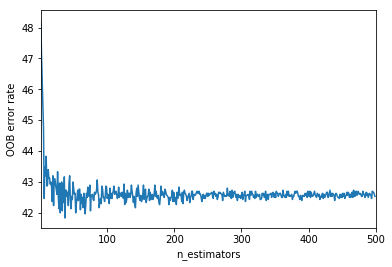

In [19]:
# 6.3.2 Random Forest (Cont') - Visualization of OOB by n_estimators
import time
warnings.filterwarnings('ignore')

forest_oob = RandomForestClassifier(n_estimators=15, oob_score=True)

error_rate = []
starttime = time.time()

# Takes long time due to testing large range of estimators
for estimators in range(1, 500):
    if estimators % 100 == 0:
        print('.')
    forest_oob.set_params(n_estimators=estimators)
    forest_oob.fit(X=x_train, y=y_train)    
    error_rate.append((1-forest_oob.oob_score_) * 100)

endtime = time.time()
print('period : %d seconds'%(endtime-starttime))
    
plt.plot(range(1, 500), error_rate)
plt.xlim(1, 500)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.show()    

* 아래 코드는 두 개의 독립변수를 가지고 랜덤포레스트가 예측한 결과를 시각화한것이다.

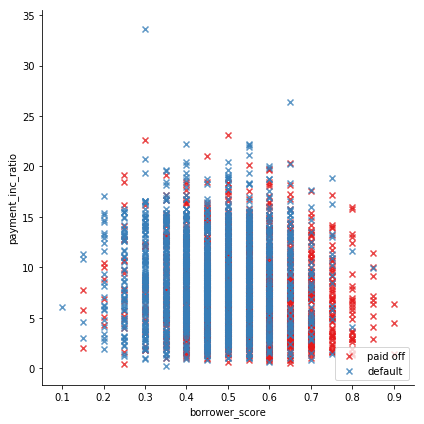

In [20]:
# 6.3.2 Random Forest (Cont') - Visualization of prediction by RandomForest
pred_oob = forest_oob.predict(x_train)

rf_df = x_train.copy()
rf_df['pred_default'] = pd.DataFrame(pred_oob, columns = ['pred_default'])

sns.lmplot( x="borrower_score", y="payment_inc_ratio", data=rf_df, fit_reg=False, hue='pred_default', legend=False, 
           palette="Set1", markers=["x", "x"], height=6, aspect=1)
plt.legend(loc='lower right')

### 6.3.3 변수 중요도

* 랜덤포레스트는 변수와 레코드의 갯수가 많은 데이터에 대한 예측 모델을 만들때 장점을 발휘한다.
* 변수중 어떤 것이 중요한지 이들 사이에 존재하는 상관관계와 같은 복잡한 관계들을 자동으로 결정하는 데 탁월한 것으로 알려져있다.  변수 중요도는 정확도 감소의 정도나 불순도 점수의 평균 감소량을 바탕으로 측정하는 2가지 방법이 있는데, 파이썬에서는 불순도 점수의 평균 감소량 기반의 측정 방법만을 제공 하고 있다.
 * 불순도 점수의 평균 감소량 기반 변수 중요도가 가지는 의미는 특정 변수가 노드의 순도를 개선하는 데 얼마나 기여했는 지를 나타낸다.  
 * 정확도 감소 기반의 변수 중요도는 특정 변수가 예측의 정확도(OOB Error Rate)에 미치는 영향의 정도를 나타낸다고 보면 된다.
* 아래 코드에서는 대출 데이터에서 모둘 변수를 고려하여 예측한 후, 불순도 감소량 기반의 중요한 순서대로 열거해서 보여주고 있다.

In [21]:
# 6.3.3. Feature Importance

from sklearn import preprocessing
le = preprocessing.LabelEncoder()

# x_train <- all features but 'outcome'
# y_train <- 'outcome'
features_3_3 = ['loan_amnt', 'term', 'annual_inc', 'dti',
       'payment_inc_ratio', 'revol_bal', 'revol_util', 
       'delinq_2yrs_zero', 'pub_rec_zero', 'open_acc',
       'grade', 'purpose_', 'home_', 'emp_len_',
       'borrower_score']
x_train = loan_data[features_3_3].copy()
y_train = loan_data.outcome.copy()

# Label encoding for categorical features
cat_features = ['term', 'purpose_', 'home_', 'emp_len_']
for feature in cat_features:    
    le.fit(x_train[feature].unique())
    x_train[feature] = le.transform(x_train[feature])

forest_3_3 = RandomForestClassifier(n_estimators=500, oob_score=True)

print('fitting a random forest to labeled training data...')
forest_3_3 = forest_3_3.fit(X=x_train, y=y_train)

print('predicting with training data...')
pred_3_3 = forest_3_3.predict(x_train)

conf_matrix_3_3 = confusion_matrix(y_train, pred_3_3, labels=['paid off', 'default'])
print('Out-of-Bag estimate of error rate: %f'%((1-forest_3_3.oob_score_)*100))
print()
print(conf_matrix_3_3)

fitting a random forest to labeled training data...
predicting with training data...
Out-of-Bag estimate of error rate: 33.796480

[[22671     0]
 [    0 22671]]


In [22]:
# 6.3.3. (Cont')
print('Feature Importance by Gini Decrease')
importance_df = pd.DataFrame(x_train.columns, columns=['feature'])
importance_df['importance'] = pd.DataFrame(forest_3_3.feature_importances_)
importance_df.sort_values(by='importance', ascending=False).head(15)

Feature Importance by Gini Decrease


,feature,importance
4,payment_inc_ratio,0.118244
3,dti,0.111077
6,revol_util,0.108404
5,revol_bal,0.106173
2,annual_inc,0.101207
10,grade,0.100881
14,borrower_score,0.090014
0,loan_amnt,0.086647
9,open_acc,0.072572
11,purpose_,0.037591


In [114]:
# 6.4.2 XGBoost 

import xgboost as xgb
from sklearn import preprocessing
from sklearn.metrics import accuracy_score

features_4_2 = ['outcome', 'borrower_score', 'payment_inc_ratio']
x_train = loan_data3000[features_4_2].copy()

# encoding label to be 0/1
le = preprocessing.LabelEncoder()
le.fit(x_train.outcome)
x_train.outcome = le.transform(x_train.outcome)
y_train = x_train.outcome
x_train = x_train.iloc[:,1:]
dtrain = xgb.DMatrix(x_train, label=y_train)

In [118]:
# 6.4.2 XGBoost (Cont')
watchlist = [(dtrain, 'train')]
num_class = len(y_train.unique())
param = {'objective':'binary:logistic',
         'eta':'0.1', 'max_depth':3,
         'silent':1, 'nthread':-1,
         'subsample': 0.63,
         'eval_metric':'error'}

In [146]:
# 6.4.2 XGBoost (Cont')
# Tested with num_boost_round as 100 to 10000. Training accuracy ranged 67.17% to 99.13% though it is overfitted.

model = xgb.train(param, dtrain, num_boost_round=1000, watchlist, verbose_eval = 100)
pred = model.predict(dtrain)
# the predict's output is a list of probability, so it should be rounded
pred = [round(value) for value in pred]
accuracy = accuracy_score(y_train, pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[0]	train-error:0.377333
[100]	train-error:0.326
[200]	train-error:0.300333
[300]	train-error:0.284667
[400]	train-error:0.270667
[500]	train-error:0.253
[600]	train-error:0.244333
[700]	train-error:0.231667
[800]	train-error:0.228667
[900]	train-error:0.218
[999]	train-error:0.212667
Accuracy: 78.73%


In [122]:
# 6.4.2 XGBoost by sklearn wrapper
from xgboost import XGBClassifier

model_sl = XGBClassifier(subsample=0.63, max_depth=10, nthread=-1)
model_sl.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=-1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.63)

In [125]:
pred_sl = model_sl.predict(x_train)
pred_sl = [round(value) for value in pred_sl]
accuracy_sl = accuracy_score(y_train, pred_sl)
print("Accuracy: %.2f%%" % (accuracy_sl * 100.0))

Accuracy: 83.60%


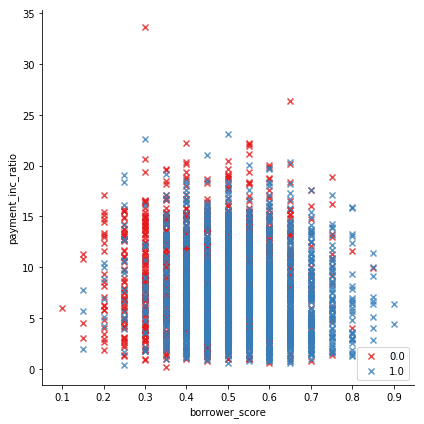

In [28]:
xgb_df = x_train.copy()
xgb_df['pred_paid_off'] = pd.DataFrame(pred, columns = ['pred_paid_off'])

sns.lmplot( x="borrower_score", y="payment_inc_ratio", data=xgb_df, fit_reg=False, hue='pred_paid_off', legend=False, 
           palette="Set1", markers=["x", "x"], height=6, aspect=1)
plt.legend(loc='lower right')

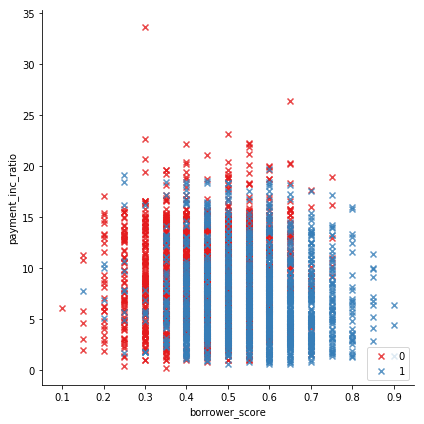

In [29]:
xgb_df_sl = x_train.copy()
xgb_df_sl['pred_paid_off'] = pd.DataFrame(pred_sl, columns = ['pred_paid_off'])

sns.lmplot( x="borrower_score", y="payment_inc_ratio", data=xgb_df_sl, fit_reg=False, hue='pred_paid_off', legend=False, 
           palette="Set1", markers=["x", "x"], height=6, aspect=1)
plt.legend(loc='lower right')

In [30]:
# 6.4.3 Avoiding over-fitting by Regularization

from sklearn.model_selection import train_test_split

# first overfitted example 
features_4_3 = ['loan_amnt', 'term', 'annual_inc', 'dti',
       'payment_inc_ratio', 'revol_bal', 'revol_util', 
       'delinq_2yrs_zero', 'pub_rec_zero', 'open_acc',
       'grade', 'purpose_', 'home_', 'emp_len_',
       'borrower_score']
x_train_4_3 = loan_data[features_4_3].copy()
y_train_4_3 = loan_data.outcome.copy()

# Label encoding for categorical features
cat_features = ['term', 'purpose_', 'home_', 'emp_len_']
for feature in cat_features:    
    le.fit(x_train_4_3[feature].unique())
    x_train_4_3[feature] = le.transform(x_train_4_3[feature])

x_train_4_3, x_test_4_3, y_train_4_3, y_test_4_3 = train_test_split(x_train_4_3, y_train_4_3, test_size = 0.22, random_state=2019)

model_of = XGBClassifier(subsample=0.63, max_depth=10, nthread=-1, n_estimators=500)
model_of.fit(x_train_4_3, y_train_4_3)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=-1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.63)

In [31]:
# 6.4.3 (Cont')

pred_4_3 = model_of.predict(x_train_4_3)
accuracy_4_3 = accuracy_score(y_train_4_3, pred_4_3)
print("Error on training-data: %.2f%%" % (100 - accuracy_4_3 * 100.0))

pred_4_3 = model_of.predict(x_test_4_3)
accuracy_4_3 = accuracy_score(y_test_4_3, pred_4_3)
print("Error on test-data: %.2f%%" % (100 - accuracy_4_3 * 100.0))

Error on training-data: 0.10%
Error on test-data: 35.55%


In [32]:
# 6.4.3 (Cont') 

model_rl = XGBClassifier(subsample=0.63, max_depth=10, nthread=-1, n_estimators=500, reg_lambda=1000)
model_rl.fit(x_train_4_3, y_train_4_3)

pred_4_3_rl = model_rl.predict(x_train_4_3)
accuracy_4_3 = accuracy_score(y_train_4_3, pred_4_3_rl)
print("Error on training-data: %.2f%%" % (100 - accuracy_4_3 * 100.0))

pred_4_3_rl = model_rl.predict(x_test_4_3)
accuracy_4_3 = accuracy_score(y_test_4_3, pred_4_3_rl)
print("Error on test-data: %.2f%%" % (100 - accuracy_4_3 * 100.0))

Error on training-data: 28.00%
Error on test-data: 33.12%


In [33]:
# 6.4.3 (Cont') iteration with ntree_limit for penalization

error_default = []
error_penalty = []

for i in range(1,250):
    pred_4_3_def = model_of.predict(x_test_4_3, ntree_limit=i)
    error_default.append(100 - accuracy_score(y_test_4_3, pred_4_3_def) * 100)
    pred_4_3_pen = model_rl.predict(x_test_4_3, ntree_limit=i)
    error_penalty.append(100 - accuracy_score(y_test_4_3, pred_4_3_pen) * 100)
    

Text(0, 0.5, 'Error')

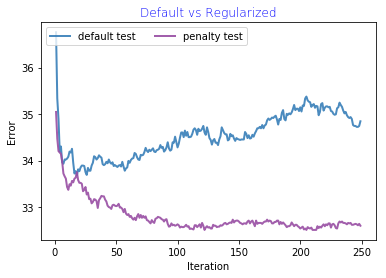

In [34]:
# 6.4.4 Hyperparameters and Cross-Validation

palette = plt.get_cmap('Set1')
plt.plot(range(1,250), error_default, marker='', color=palette(1), linewidth=2, alpha=0.9, label='default test')
plt.plot(range(1,250), error_penalty, marker='', color=palette(3), linewidth=2, alpha=0.9, label='penalty test')

# Add legend
plt.legend(loc=2, ncol=2)
 
# Add titles
plt.title("Default vs Regularized", fontsize=12, fontweight=2, color='blue')
plt.xlabel("Iteration")
plt.ylabel("Error")

In [35]:
# 6.4.4 Hyperparameters and Cross-Validation

from sklearn.model_selection import KFold

# first overfitted example 
features_4_4 = ['loan_amnt', 'term', 'annual_inc', 'dti',
       'payment_inc_ratio', 'revol_bal', 'revol_util', 
       'delinq_2yrs_zero', 'pub_rec_zero', 'open_acc',
       'grade', 'purpose_', 'home_', 'emp_len_',
       'borrower_score']
x_train_4_4 = loan_data[features_4_4].copy()
y_train_4_4 = loan_data.outcome.copy()

# Label encoding for categorical features
cat_features = ['term', 'purpose_', 'home_', 'emp_len_']
for feature in cat_features:    
    le.fit(x_train_4_4[feature].unique())
    x_train_4_4[feature] = le.transform(x_train_4_4[feature])

kf = KFold(n_splits=5)

In [36]:
etas = [0.1, 0.5, 0.9] * 3
depth = [3, 6, 12] * 3
depth.sort()

params = pd.DataFrame({'eta':etas, 'max_depth':depth})      
errors = []

In [37]:
import time
starttime = time.time()
for row in range(0, params.shape[0]):    
    print('training with %.2f learning rate and %d max_depth'%(params.eta[row], params.max_depth[row]))
    for train_index, test_index in kf.split(X=x_train_4_4):
        print('\ttrain index : %d \ttest index: %d'%(train_index[0], test_index[0]))
        x_train_4_4_f = x_train_4_4.iloc[train_index]
        y_train_4_4_f = y_train_4_4.iloc[train_index]
        x_test_4_4_f = x_train_4_4.iloc[test_index]
        y_test_4_4_f = y_train_4_4.iloc[test_index]

        model_4_4 = XGBClassifier(subsample=0.63, learning_rate=params.eta[row], max_depth=params.max_depth[row], nthread=-1, n_estimators=500, reg_lambda=1000)
        model_4_4.fit(x_train_4_4_f, y_train_4_4_f)
        pred_4_4 = model_4_4.predict(x_test_4_4_f, ntree_limit=200)
        errors.append(100 - accuracy_score(y_test_4_4_f, pred_4_4) * 100.0)        

endtime = time.time()
print('time spent: %d s'%(endtime - starttime))

training with 0.10 learning rate and 3 max_depth
	train index : 9069 	test index: 0
	train index : 0 	test index: 9069
	train index : 0 	test index: 18138
	train index : 0 	test index: 27206
	train index : 0 	test index: 36274
training with 0.50 learning rate and 3 max_depth
	train index : 9069 	test index: 0
	train index : 0 	test index: 9069
	train index : 0 	test index: 18138
	train index : 0 	test index: 27206
	train index : 0 	test index: 36274
training with 0.90 learning rate and 3 max_depth
	train index : 9069 	test index: 0
	train index : 0 	test index: 9069
	train index : 0 	test index: 18138
	train index : 0 	test index: 27206
	train index : 0 	test index: 36274
training with 0.10 learning rate and 6 max_depth
	train index : 9069 	test index: 0
	train index : 0 	test index: 9069
	train index : 0 	test index: 18138
	train index : 0 	test index: 27206
	train index : 0 	test index: 36274
training with 0.50 learning rate and 6 max_depth
	train index : 9069 	test index: 0
	train i

In [101]:
errors = np.array(errors)
errors = errors.reshape(9,5)
errors_df = pd.DataFrame(errors)
errors_df['avg'] = errors_df.transpose().mean()
params['avg_error'] = errors_df.avg
params.head(9)

,eta,max_depth,avg_error
0,0.1,3,53.424719
1,0.5,3,53.863556
2,0.9,3,54.137010
3,0.1,6,53.400456
4,0.5,6,54.062050
5,0.9,6,54.372989
6,0.1,12,53.667306
7,0.5,12,54.344333
8,0.9,12,54.425936


In [192]:
errors_xgb = []
starttime = time.time()

le.fit(y_train_4_4)
y_train_4_4 = le.transform(y_train_4_4)

for row in range(0, params.shape[0]):    
    print('training with %.2f learning rate and %d max_depth'%(params.eta[row], params.max_depth[row]))
    for train_index, test_index in kf.split(X=x_train_4_4):
        print('\ttrain index : %d \ttest index: %d'%(train_index[0], test_index[0]))
        param = {'objective':'binary:logistic',
         'eta':params.eta[row], 'max_depth':params.max_depth[row],
         'silent':1, 'nthread':-1,
         'subsample': 0.63, 'reg_lambda': 200,
         'n_estimator': 500,
         'eval_metric':'error'}
        
        dtrain_4_4 = xgb.DMatrix(x_train_4_4.iloc[train_index], label=y_train_4_4[train_index])
        dtest_4_4 = xgb.DMatrix(x_train_4_4.iloc[test_index], label=y_train_4_4[test_index])

        watchlist = [(dtest_4_4,'eval'), (dtrain_4_4,'train')]
        
        model_4_4_xgb = xgb.train(param, dtrain_4_4, num_boost_round=2000, verbose_eval=False)
        pred_4_4_xgb = model_4_4_xgb.predict(dtest_4_4, ntree_limit=200)
        pred_4_4_xgb = [round(value) for value in pred_4_4_xgb]
        errors_xgb.append(100 - accuracy_score(dtest_4_4.get_label(), pred_4_4_xgb) * 100.0)        

endtime = time.time()
print('time spent: %d s'%(endtime - starttime))

training with 0.10 learning rate and 3 max_depth
	train index : 9069 	test index: 0
	train index : 0 	test index: 9069
	train index : 0 	test index: 18138
	train index : 0 	test index: 27206
	train index : 0 	test index: 36274
training with 0.50 learning rate and 3 max_depth
	train index : 9069 	test index: 0
	train index : 0 	test index: 9069
	train index : 0 	test index: 18138
	train index : 0 	test index: 27206
	train index : 0 	test index: 36274
training with 0.90 learning rate and 3 max_depth
	train index : 9069 	test index: 0


KeyboardInterrupt: 

In [ ]:
errors_xgb = np.array(errors_xgb)
errors_xgb = errors_xgb.reshape(9,5)
errors_df_xgb = pd.DataFrame(errors_xgb)
errors_df_xgb['avg'] = errors_df_xgb.transpose().mean()
params['avg_error_xgb'] = errors_df_xgb.avg
params.head(9)